In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, get_bounding_box_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,extract_other_sensor_token,transform_box_from_world_to_sendor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion
from lyft_dataset_sdk.utils.geometry_utils import points_in_box

In [3]:
from provider import FrustumDataset

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/kanhua/miniconda3/envs/lyft-3d

In [4]:
lyft_data_file="/Users/kanhua/Dropbox/Programming/lyft-3d-main/artifact/lyft_val.pickle"
kitti_data_file="/Users/kanhua/Downloads/frustum-pointnets/kitti/frustum_carpedcyc_val.pickle"
NUM_POINT=1024

In [5]:
dataset=FrustumDataset(npoints=NUM_POINT,split='val',
                       from_rgb_detection=False,
                    overwritten_data_path=kitti_data_file,one_hot=True,rotate_to_center=True)

In [6]:
dataset[1]

(array([[-1.0105195 ,  2.447741  , 37.76408   ,  0.        ],
        [-0.14278868,  1.3395798 , 33.40884   ,  0.        ],
        [-0.8500597 ,  2.327134  , 36.09393   ,  0.        ],
        ...,
        [-1.066927  ,  2.5498827 , 42.374676  ,  0.        ],
        [-0.8500597 ,  2.327134  , 36.09393   ,  0.        ],
        [ 0.8162382 ,  2.1547415 , 33.947994  ,  0.        ]],
       dtype=float32),
 array([0., 1., 0., ..., 0., 0., 1.]),
 array([-8.95501188e-03,  1.56500000e+00,  3.45267537e+01]),
 9,
 -0.10169624008583789,
 0,
 array([ 0.4768836 , -0.0485674 , -0.11563191]),
 0.09249256688073482,
 array([1., 0., 0.]))

In [7]:
a=dataset[1]

In [8]:
len(a)

9

In [9]:
type(dataset.input_list)

list

In [10]:
pointset=a[0]
seg=a[1]
box3d_center=a[2]
rot_angle=a[7]

In [11]:
box3d_center

array([-8.95501188e-03,  1.56500000e+00,  3.45267537e+01])

In [12]:
rot_angle

0.09249256688073482

In [13]:
def rad2deg(radius):
    return radius*180/np.pi

In [14]:
rad2deg(rot_angle)

5.299433718597602

In [15]:
seg=seg.astype(bool)

In [16]:
pointset_before_transformation=dataset.input_list[1]

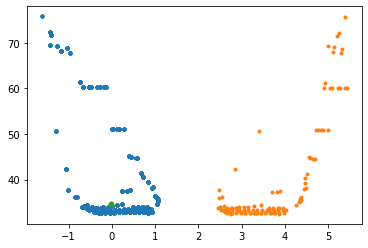

In [17]:
plt.plot(pointset[:,0],pointset[:,2],'.')
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
#plt.plot(pointset[seg,0],pointset[seg,2],'.')
plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)

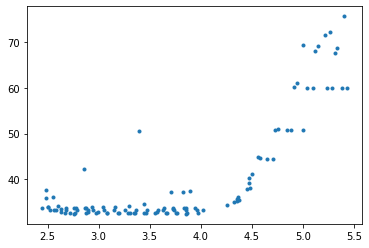

In [18]:
plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')

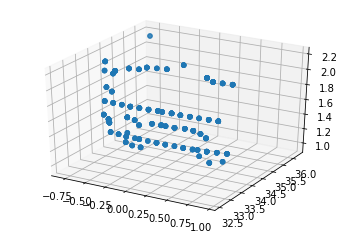

In [19]:
sel_pointset=pointset[seg,:]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pointset[:,0], pointset[:,2], pointset[:,1])
ax.scatter(sel_pointset[:,0],sel_pointset[:,2],sel_pointset[:,1])

## See inference results

In [27]:
import tensorflow as tf
import importlib
from train_util import get_batch
from model_util import NUM_HEADING_BIN, NUM_SIZE_CLUSTER
# Set training configurations
BATCH_SIZE = 1
MODEL_PATH = "/Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt"
GPU_INDEX = 0
MODEL = importlib.import_module("frustum_pointnets_v1")
NUM_CLASSES = 2
NUM_CHANNEL = 4

In [28]:
# functions excerpted from frustum-pointnet test.py
def get_session_and_ops(batch_size, num_point):
    ''' Define model graph, load model parameters,
    create session and return session handle and tensors
    '''
    with tf.Graph().as_default():
        with tf.device('/gpu:' + str(GPU_INDEX)):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                MODEL.placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = MODEL.get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = MODEL.get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, MODEL_PATH)
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape) - 1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape) - 1, keepdims=True)
    return probs


def inference(sess, ops, pc, one_hot_vec, batch_size):
    ''' Run inference for frustum pointnets in batch mode '''
    assert pc.shape[0] % batch_size == 0
    num_batches = int(pc.shape[0] / batch_size)
    logits = np.zeros((pc.shape[0], pc.shape[1], NUM_CLASSES))
    centers = np.zeros((pc.shape[0], 3))
    heading_logits = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    heading_residuals = np.zeros((pc.shape[0], NUM_HEADING_BIN))
    size_logits = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER))
    size_residuals = np.zeros((pc.shape[0], NUM_SIZE_CLUSTER, 3))
    scores = np.zeros((pc.shape[0],))  # 3D box score

    ep = ops['end_points']
    for i in range(num_batches):
        feed_dict = { \
            ops['pointclouds_pl']: pc[i * batch_size:(i + 1) * batch_size, ...],
            ops['one_hot_vec_pl']: one_hot_vec[i * batch_size:(i + 1) * batch_size, :],
            ops['is_training_pl']: False}

        batch_logits, batch_centers, \
        batch_heading_scores, batch_heading_residuals, \
        batch_size_scores, batch_size_residuals = \
            sess.run([ops['logits'], ops['center'],
                      ep['heading_scores'], ep['heading_residuals'],
                      ep['size_scores'], ep['size_residuals']],
                     feed_dict=feed_dict)

        logits[i * batch_size:(i + 1) * batch_size, ...] = batch_logits
        centers[i * batch_size:(i + 1) * batch_size, ...] = batch_centers
        heading_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_scores
        heading_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_heading_residuals
        size_logits[i * batch_size:(i + 1) * batch_size, ...] = batch_size_scores
        size_residuals[i * batch_size:(i + 1) * batch_size, ...] = batch_size_residuals

        # Compute scores
        batch_seg_prob = softmax(batch_logits)[:, :, 1]  # BxN
        batch_seg_mask = np.argmax(batch_logits, 2)  # BxN
        mask_mean_prob = np.sum(batch_seg_prob * batch_seg_mask, 1)  # B,
        mask_mean_prob = mask_mean_prob / np.sum(batch_seg_mask, 1)  # B,
        heading_prob = np.max(softmax(batch_heading_scores), 1)  # B
        size_prob = np.max(softmax(batch_size_scores), 1)  # B,
        batch_scores = np.log(mask_mean_prob) + np.log(heading_prob) + np.log(size_prob)
        scores[i * batch_size:(i + 1) * batch_size] = batch_scores
        # Finished computing scores

    heading_cls = np.argmax(heading_logits, 1)  # B
    size_cls = np.argmax(size_logits, 1)  # B
    heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                            for i in range(pc.shape[0])])
    size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                          for i in range(pc.shape[0])])

    return np.argmax(logits, 2), centers, heading_cls, heading_res, \
           size_cls, size_res, scores

In [29]:
sess, ops = get_session_and_ops(batch_size=BATCH_SIZE, num_point=NUM_POINT)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from /Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt


In [30]:
result_dir=None
TEST_DATASET=dataset

## Proecedures of test()
ps_list = []
seg_list = []
segp_list = []
center_list = []
heading_cls_list = []
heading_res_list = []
size_cls_list = []
size_res_list = []
rot_angle_list = []
score_list = []

test_idxs = np.arange(0, len(TEST_DATASET))
batch_size = BATCH_SIZE
num_batches = int(len(TEST_DATASET) / batch_size)
assert ((len(TEST_DATASET) % int(batch_size)) == 0)

sess, ops = get_session_and_ops(batch_size=batch_size, num_point=NUM_POINT)
correct_cnt = 0
for batch_idx in range(num_batches):
    #print('batch idx: %d' % (batch_idx))
    start_idx = batch_idx * batch_size
    end_idx = (batch_idx + 1) * batch_size

    batch_data, batch_label, batch_center, \
    batch_hclass, batch_hres, batch_sclass, batch_sres, \
    batch_rot_angle, batch_one_hot_vec = \
        get_batch(TEST_DATASET, test_idxs, start_idx, end_idx,
                  NUM_POINT, NUM_CHANNEL)

    batch_output, batch_center_pred, \
    batch_hclass_pred, batch_hres_pred, \
    batch_sclass_pred, batch_sres_pred, batch_scores = \
        inference(sess, ops, batch_data,
                  batch_one_hot_vec, batch_size=batch_size)

    correct_cnt += np.sum(batch_output == batch_label)

    for i in range(batch_output.shape[0]):
        ps_list.append(batch_data[i, ...])
        seg_list.append(batch_label[i, ...])
        segp_list.append(batch_output[i, ...])
        center_list.append(batch_center_pred[i, :])
        heading_cls_list.append(batch_hclass_pred[i])
        heading_res_list.append(batch_hres_pred[i])
        size_cls_list.append(batch_sclass_pred[i])
        size_res_list.append(batch_sres_pred[i, :])
        rot_angle_list.append(batch_rot_angle[i])
        score_list.append(batch_scores[i])

print("Segmentation accuracy: %f" % \
      (correct_cnt / float(batch_size * num_batches * NUM_POINT)))

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from /Users/kanhua/Downloads/frustum-pointnets/train/log_v1/model.ckpt
batch idx: 0
batch idx: 1
batch idx: 2
batch idx: 3
batch idx: 4
batch idx: 5
batch idx: 6
batch idx: 7
batch idx: 8
batch idx: 9
batc

/Users/kanhua/miniconda3/envs/lyft-3d/lib/python3.7/site-packages/ipykernel_launcher.py:88: RuntimeWarning: invalid value encountered in true_divide


batch idx: 96
batch idx: 97
batch idx: 98
batch idx: 99
batch idx: 100
batch idx: 101
batch idx: 102
batch idx: 103
batch idx: 104
batch idx: 105
batch idx: 106
batch idx: 107
batch idx: 108
batch idx: 109
batch idx: 110
batch idx: 111
batch idx: 112
batch idx: 113
batch idx: 114
batch idx: 115
batch idx: 116
batch idx: 117
batch idx: 118
batch idx: 119
batch idx: 120
batch idx: 121
batch idx: 122
batch idx: 123
batch idx: 124
batch idx: 125
batch idx: 126
batch idx: 127
batch idx: 128
batch idx: 129
batch idx: 130
batch idx: 131
batch idx: 132
batch idx: 133
batch idx: 134
batch idx: 135
batch idx: 136
batch idx: 137
batch idx: 138
batch idx: 139
batch idx: 140
batch idx: 141
batch idx: 142
batch idx: 143
batch idx: 144
batch idx: 145
batch idx: 146
batch idx: 147
batch idx: 148
batch idx: 149
batch idx: 150
batch idx: 151
batch idx: 152
batch idx: 153
batch idx: 154
batch idx: 155
batch idx: 156
batch idx: 157
batch idx: 158
batch idx: 159
batch idx: 160
batch idx: 161
batch idx: 162

batch idx: 645
batch idx: 646
batch idx: 647
batch idx: 648
batch idx: 649
batch idx: 650
batch idx: 651
batch idx: 652
batch idx: 653
batch idx: 654
batch idx: 655
batch idx: 656
batch idx: 657
batch idx: 658
batch idx: 659
batch idx: 660
batch idx: 661
batch idx: 662
batch idx: 663
batch idx: 664
batch idx: 665
batch idx: 666
batch idx: 667
batch idx: 668
batch idx: 669
batch idx: 670
batch idx: 671
batch idx: 672
batch idx: 673
batch idx: 674
batch idx: 675
batch idx: 676
batch idx: 677
batch idx: 678
batch idx: 679
batch idx: 680
batch idx: 681
batch idx: 682
batch idx: 683
batch idx: 684
batch idx: 685
batch idx: 686
batch idx: 687
batch idx: 688
batch idx: 689
batch idx: 690
batch idx: 691
batch idx: 692
batch idx: 693
batch idx: 694
batch idx: 695
batch idx: 696
batch idx: 697
batch idx: 698
batch idx: 699
batch idx: 700
batch idx: 701
batch idx: 702
batch idx: 703
batch idx: 704
batch idx: 705
batch idx: 706
batch idx: 707
batch idx: 708
batch idx: 709
batch idx: 710
batch idx:

batch idx: 1185
batch idx: 1186
batch idx: 1187
batch idx: 1188
batch idx: 1189
batch idx: 1190
batch idx: 1191
batch idx: 1192
batch idx: 1193
batch idx: 1194
batch idx: 1195
batch idx: 1196
batch idx: 1197
batch idx: 1198
batch idx: 1199
batch idx: 1200
batch idx: 1201
batch idx: 1202
batch idx: 1203
batch idx: 1204
batch idx: 1205
batch idx: 1206
batch idx: 1207
batch idx: 1208
batch idx: 1209
batch idx: 1210
batch idx: 1211
batch idx: 1212
batch idx: 1213
batch idx: 1214
batch idx: 1215
batch idx: 1216
batch idx: 1217
batch idx: 1218
batch idx: 1219
batch idx: 1220
batch idx: 1221
batch idx: 1222
batch idx: 1223
batch idx: 1224
batch idx: 1225
batch idx: 1226
batch idx: 1227
batch idx: 1228
batch idx: 1229
batch idx: 1230
batch idx: 1231
batch idx: 1232
batch idx: 1233
batch idx: 1234
batch idx: 1235
batch idx: 1236
batch idx: 1237
batch idx: 1238
batch idx: 1239
batch idx: 1240
batch idx: 1241
batch idx: 1242
batch idx: 1243
batch idx: 1244
batch idx: 1245
batch idx: 1246
batch id

batch idx: 1702
batch idx: 1703
batch idx: 1704
batch idx: 1705
batch idx: 1706
batch idx: 1707
batch idx: 1708
batch idx: 1709
batch idx: 1710
batch idx: 1711
batch idx: 1712
batch idx: 1713
batch idx: 1714
batch idx: 1715
batch idx: 1716
batch idx: 1717
batch idx: 1718
batch idx: 1719
batch idx: 1720
batch idx: 1721
batch idx: 1722
batch idx: 1723
batch idx: 1724
batch idx: 1725
batch idx: 1726
batch idx: 1727
batch idx: 1728
batch idx: 1729
batch idx: 1730
batch idx: 1731
batch idx: 1732
batch idx: 1733
batch idx: 1734
batch idx: 1735
batch idx: 1736
batch idx: 1737
batch idx: 1738
batch idx: 1739
batch idx: 1740
batch idx: 1741
batch idx: 1742
batch idx: 1743
batch idx: 1744
batch idx: 1745
batch idx: 1746
batch idx: 1747
batch idx: 1748
batch idx: 1749
batch idx: 1750
batch idx: 1751
batch idx: 1752
batch idx: 1753
batch idx: 1754
batch idx: 1755
batch idx: 1756
batch idx: 1757
batch idx: 1758
batch idx: 1759
batch idx: 1760
batch idx: 1761
batch idx: 1762
batch idx: 1763
batch id

batch idx: 2216
batch idx: 2217
batch idx: 2218
batch idx: 2219
batch idx: 2220
batch idx: 2221
batch idx: 2222
batch idx: 2223
batch idx: 2224
batch idx: 2225
batch idx: 2226
batch idx: 2227
batch idx: 2228
batch idx: 2229
batch idx: 2230
batch idx: 2231
batch idx: 2232
batch idx: 2233
batch idx: 2234
batch idx: 2235
batch idx: 2236
batch idx: 2237
batch idx: 2238
batch idx: 2239
batch idx: 2240
batch idx: 2241
batch idx: 2242
batch idx: 2243
batch idx: 2244
batch idx: 2245
batch idx: 2246
batch idx: 2247
batch idx: 2248
batch idx: 2249
batch idx: 2250
batch idx: 2251
batch idx: 2252
batch idx: 2253
batch idx: 2254
batch idx: 2255
batch idx: 2256
batch idx: 2257
batch idx: 2258
batch idx: 2259
batch idx: 2260
batch idx: 2261
batch idx: 2262
batch idx: 2263
batch idx: 2264
batch idx: 2265
batch idx: 2266
batch idx: 2267
batch idx: 2268
batch idx: 2269
batch idx: 2270
batch idx: 2271
batch idx: 2272
batch idx: 2273
batch idx: 2274
batch idx: 2275
batch idx: 2276
batch idx: 2277
batch id

batch idx: 2732
batch idx: 2733
batch idx: 2734
batch idx: 2735
batch idx: 2736
batch idx: 2737
batch idx: 2738
batch idx: 2739
batch idx: 2740
batch idx: 2741
batch idx: 2742
batch idx: 2743
batch idx: 2744
batch idx: 2745
batch idx: 2746
batch idx: 2747
batch idx: 2748
batch idx: 2749
batch idx: 2750
batch idx: 2751
batch idx: 2752
batch idx: 2753
batch idx: 2754
batch idx: 2755
batch idx: 2756
batch idx: 2757
batch idx: 2758
batch idx: 2759
batch idx: 2760
batch idx: 2761
batch idx: 2762
batch idx: 2763
batch idx: 2764
batch idx: 2765
batch idx: 2766
batch idx: 2767
batch idx: 2768
batch idx: 2769
batch idx: 2770
batch idx: 2771
batch idx: 2772
batch idx: 2773
batch idx: 2774
batch idx: 2775
batch idx: 2776
batch idx: 2777
batch idx: 2778
batch idx: 2779
batch idx: 2780
batch idx: 2781
batch idx: 2782
batch idx: 2783
batch idx: 2784
batch idx: 2785
batch idx: 2786
batch idx: 2787
batch idx: 2788
batch idx: 2789
batch idx: 2790
batch idx: 2791
batch idx: 2792
batch idx: 2793
batch id

batch idx: 3250
batch idx: 3251
batch idx: 3252
batch idx: 3253
batch idx: 3254
batch idx: 3255
batch idx: 3256
batch idx: 3257
batch idx: 3258
batch idx: 3259
batch idx: 3260
batch idx: 3261
batch idx: 3262
batch idx: 3263
batch idx: 3264
batch idx: 3265
batch idx: 3266
batch idx: 3267
batch idx: 3268
batch idx: 3269
batch idx: 3270
batch idx: 3271
batch idx: 3272
batch idx: 3273
batch idx: 3274
batch idx: 3275
batch idx: 3276
batch idx: 3277
batch idx: 3278
batch idx: 3279
batch idx: 3280
batch idx: 3281
batch idx: 3282
batch idx: 3283
batch idx: 3284
batch idx: 3285
batch idx: 3286
batch idx: 3287
batch idx: 3288
batch idx: 3289
batch idx: 3290
batch idx: 3291
batch idx: 3292
batch idx: 3293
batch idx: 3294
batch idx: 3295
batch idx: 3296
batch idx: 3297
batch idx: 3298
batch idx: 3299
batch idx: 3300
batch idx: 3301
batch idx: 3302
batch idx: 3303
batch idx: 3304
batch idx: 3305
batch idx: 3306
batch idx: 3307
batch idx: 3308
batch idx: 3309
batch idx: 3310
batch idx: 3311
batch id

batch idx: 3763
batch idx: 3764
batch idx: 3765
batch idx: 3766
batch idx: 3767
batch idx: 3768
batch idx: 3769
batch idx: 3770
batch idx: 3771
batch idx: 3772
batch idx: 3773
batch idx: 3774
batch idx: 3775
batch idx: 3776
batch idx: 3777
batch idx: 3778
batch idx: 3779
batch idx: 3780
batch idx: 3781
batch idx: 3782
batch idx: 3783
batch idx: 3784
batch idx: 3785
batch idx: 3786
batch idx: 3787
batch idx: 3788
batch idx: 3789
batch idx: 3790
batch idx: 3791
batch idx: 3792
batch idx: 3793
batch idx: 3794
batch idx: 3795
batch idx: 3796
batch idx: 3797
batch idx: 3798
batch idx: 3799
batch idx: 3800
batch idx: 3801
batch idx: 3802
batch idx: 3803
batch idx: 3804
batch idx: 3805
batch idx: 3806
batch idx: 3807
batch idx: 3808
batch idx: 3809
batch idx: 3810
batch idx: 3811
batch idx: 3812
batch idx: 3813
batch idx: 3814
batch idx: 3815
batch idx: 3816
batch idx: 3817
batch idx: 3818
batch idx: 3819
batch idx: 3820
batch idx: 3821
batch idx: 3822
batch idx: 3823
batch idx: 3824
batch id

batch idx: 4279
batch idx: 4280
batch idx: 4281
batch idx: 4282
batch idx: 4283
batch idx: 4284
batch idx: 4285
batch idx: 4286
batch idx: 4287
batch idx: 4288
batch idx: 4289
batch idx: 4290
batch idx: 4291
batch idx: 4292
batch idx: 4293
batch idx: 4294
batch idx: 4295
batch idx: 4296
batch idx: 4297
batch idx: 4298
batch idx: 4299
batch idx: 4300
batch idx: 4301
batch idx: 4302
batch idx: 4303
batch idx: 4304
batch idx: 4305
batch idx: 4306
batch idx: 4307
batch idx: 4308
batch idx: 4309
batch idx: 4310
batch idx: 4311
batch idx: 4312
batch idx: 4313
batch idx: 4314
batch idx: 4315
batch idx: 4316
batch idx: 4317
batch idx: 4318
batch idx: 4319
batch idx: 4320
batch idx: 4321
batch idx: 4322
batch idx: 4323
batch idx: 4324
batch idx: 4325
batch idx: 4326
batch idx: 4327
batch idx: 4328
batch idx: 4329
batch idx: 4330
batch idx: 4331
batch idx: 4332
batch idx: 4333
batch idx: 4334
batch idx: 4335
batch idx: 4336
batch idx: 4337
batch idx: 4338
batch idx: 4339
batch idx: 4340
batch id

batch idx: 4797
batch idx: 4798
batch idx: 4799
batch idx: 4800
batch idx: 4801
batch idx: 4802
batch idx: 4803
batch idx: 4804
batch idx: 4805
batch idx: 4806
batch idx: 4807
batch idx: 4808
batch idx: 4809
batch idx: 4810
batch idx: 4811
batch idx: 4812
batch idx: 4813
batch idx: 4814
batch idx: 4815
batch idx: 4816
batch idx: 4817
batch idx: 4818
batch idx: 4819
batch idx: 4820
batch idx: 4821
batch idx: 4822
batch idx: 4823
batch idx: 4824
batch idx: 4825
batch idx: 4826
batch idx: 4827
batch idx: 4828
batch idx: 4829
batch idx: 4830
batch idx: 4831
batch idx: 4832
batch idx: 4833
batch idx: 4834
batch idx: 4835
batch idx: 4836
batch idx: 4837
batch idx: 4838
batch idx: 4839
batch idx: 4840
batch idx: 4841
batch idx: 4842
batch idx: 4843
batch idx: 4844
batch idx: 4845
batch idx: 4846
batch idx: 4847
batch idx: 4848
batch idx: 4849
batch idx: 4850
batch idx: 4851
batch idx: 4852
batch idx: 4853
batch idx: 4854
batch idx: 4855
batch idx: 4856
batch idx: 4857
batch idx: 4858
batch id

batch idx: 5310
batch idx: 5311
batch idx: 5312
batch idx: 5313
batch idx: 5314
batch idx: 5315
batch idx: 5316
batch idx: 5317
batch idx: 5318
batch idx: 5319
batch idx: 5320
batch idx: 5321
batch idx: 5322
batch idx: 5323
batch idx: 5324
batch idx: 5325
batch idx: 5326
batch idx: 5327
batch idx: 5328
batch idx: 5329
batch idx: 5330
batch idx: 5331
batch idx: 5332
batch idx: 5333
batch idx: 5334
batch idx: 5335
batch idx: 5336
batch idx: 5337
batch idx: 5338
batch idx: 5339
batch idx: 5340
batch idx: 5341
batch idx: 5342
batch idx: 5343
batch idx: 5344
batch idx: 5345
batch idx: 5346
batch idx: 5347
batch idx: 5348
batch idx: 5349
batch idx: 5350
batch idx: 5351
batch idx: 5352
batch idx: 5353
batch idx: 5354
batch idx: 5355
batch idx: 5356
batch idx: 5357
batch idx: 5358
batch idx: 5359
batch idx: 5360
batch idx: 5361
batch idx: 5362
batch idx: 5363
batch idx: 5364
batch idx: 5365
batch idx: 5366
batch idx: 5367
batch idx: 5368
batch idx: 5369
batch idx: 5370
batch idx: 5371
batch id

batch idx: 5826
batch idx: 5827
batch idx: 5828
batch idx: 5829
batch idx: 5830
batch idx: 5831
batch idx: 5832
batch idx: 5833
batch idx: 5834
batch idx: 5835
batch idx: 5836
batch idx: 5837
batch idx: 5838
batch idx: 5839
batch idx: 5840
batch idx: 5841
batch idx: 5842
batch idx: 5843
batch idx: 5844
batch idx: 5845
batch idx: 5846
batch idx: 5847
batch idx: 5848
batch idx: 5849
batch idx: 5850
batch idx: 5851
batch idx: 5852
batch idx: 5853
batch idx: 5854
batch idx: 5855
batch idx: 5856
batch idx: 5857
batch idx: 5858
batch idx: 5859
batch idx: 5860
batch idx: 5861
batch idx: 5862
batch idx: 5863
batch idx: 5864
batch idx: 5865
batch idx: 5866
batch idx: 5867
batch idx: 5868
batch idx: 5869
batch idx: 5870
batch idx: 5871
batch idx: 5872
batch idx: 5873
batch idx: 5874
batch idx: 5875
batch idx: 5876
batch idx: 5877
batch idx: 5878
batch idx: 5879
batch idx: 5880
batch idx: 5881
batch idx: 5882
batch idx: 5883
batch idx: 5884
batch idx: 5885
batch idx: 5886
batch idx: 5887
batch id

batch idx: 6343
batch idx: 6344
batch idx: 6345
batch idx: 6346
batch idx: 6347
batch idx: 6348
batch idx: 6349
batch idx: 6350
batch idx: 6351
batch idx: 6352
batch idx: 6353
batch idx: 6354
batch idx: 6355
batch idx: 6356
batch idx: 6357
batch idx: 6358
batch idx: 6359
batch idx: 6360
batch idx: 6361
batch idx: 6362
batch idx: 6363
batch idx: 6364
batch idx: 6365
batch idx: 6366
batch idx: 6367
batch idx: 6368
batch idx: 6369
batch idx: 6370
batch idx: 6371
batch idx: 6372
batch idx: 6373
batch idx: 6374
batch idx: 6375
batch idx: 6376
batch idx: 6377
batch idx: 6378
batch idx: 6379
batch idx: 6380
batch idx: 6381
batch idx: 6382
batch idx: 6383
batch idx: 6384
batch idx: 6385
batch idx: 6386
batch idx: 6387
batch idx: 6388
batch idx: 6389
batch idx: 6390
batch idx: 6391
batch idx: 6392
batch idx: 6393
batch idx: 6394
batch idx: 6395
batch idx: 6396
batch idx: 6397
batch idx: 6398
batch idx: 6399
batch idx: 6400
batch idx: 6401
batch idx: 6402
batch idx: 6403
batch idx: 6404
batch id

batch idx: 6859
batch idx: 6860
batch idx: 6861
batch idx: 6862
batch idx: 6863
batch idx: 6864
batch idx: 6865
batch idx: 6866
batch idx: 6867
batch idx: 6868
batch idx: 6869
batch idx: 6870
batch idx: 6871
batch idx: 6872
batch idx: 6873
batch idx: 6874
batch idx: 6875
batch idx: 6876
batch idx: 6877
batch idx: 6878
batch idx: 6879
batch idx: 6880
batch idx: 6881
batch idx: 6882
batch idx: 6883
batch idx: 6884
batch idx: 6885
batch idx: 6886
batch idx: 6887
batch idx: 6888
batch idx: 6889
batch idx: 6890
batch idx: 6891
batch idx: 6892
batch idx: 6893
batch idx: 6894
batch idx: 6895
batch idx: 6896
batch idx: 6897
batch idx: 6898
batch idx: 6899
batch idx: 6900
batch idx: 6901
batch idx: 6902
batch idx: 6903
batch idx: 6904
batch idx: 6905
batch idx: 6906
batch idx: 6907
batch idx: 6908
batch idx: 6909
batch idx: 6910
batch idx: 6911
batch idx: 6912
batch idx: 6913
batch idx: 6914
batch idx: 6915
batch idx: 6916
batch idx: 6917
batch idx: 6918
batch idx: 6919
batch idx: 6920
batch id

batch idx: 7376
batch idx: 7377
batch idx: 7378
batch idx: 7379
batch idx: 7380
batch idx: 7381
batch idx: 7382
batch idx: 7383
batch idx: 7384
batch idx: 7385
batch idx: 7386
batch idx: 7387
batch idx: 7388
batch idx: 7389
batch idx: 7390
batch idx: 7391
batch idx: 7392
batch idx: 7393
batch idx: 7394
batch idx: 7395
batch idx: 7396
batch idx: 7397
batch idx: 7398
batch idx: 7399
batch idx: 7400
batch idx: 7401
batch idx: 7402
batch idx: 7403
batch idx: 7404
batch idx: 7405
batch idx: 7406
batch idx: 7407
batch idx: 7408
batch idx: 7409
batch idx: 7410
batch idx: 7411
batch idx: 7412
batch idx: 7413
batch idx: 7414
batch idx: 7415
batch idx: 7416
batch idx: 7417
batch idx: 7418
batch idx: 7419
batch idx: 7420
batch idx: 7421
batch idx: 7422
batch idx: 7423
batch idx: 7424
batch idx: 7425
batch idx: 7426
batch idx: 7427
batch idx: 7428
batch idx: 7429
batch idx: 7430
batch idx: 7431
batch idx: 7432
batch idx: 7433
batch idx: 7434
batch idx: 7435
batch idx: 7436
batch idx: 7437
batch id

batch idx: 7892
batch idx: 7893
batch idx: 7894
batch idx: 7895
batch idx: 7896
batch idx: 7897
batch idx: 7898
batch idx: 7899
batch idx: 7900
batch idx: 7901
batch idx: 7902
batch idx: 7903
batch idx: 7904
batch idx: 7905
batch idx: 7906
batch idx: 7907
batch idx: 7908
batch idx: 7909
batch idx: 7910
batch idx: 7911
batch idx: 7912
batch idx: 7913
batch idx: 7914
batch idx: 7915
batch idx: 7916
batch idx: 7917
batch idx: 7918
batch idx: 7919
batch idx: 7920
batch idx: 7921
batch idx: 7922
batch idx: 7923
batch idx: 7924
batch idx: 7925
batch idx: 7926
batch idx: 7927
batch idx: 7928
batch idx: 7929
batch idx: 7930
batch idx: 7931
batch idx: 7932
batch idx: 7933
batch idx: 7934
batch idx: 7935
batch idx: 7936
batch idx: 7937
batch idx: 7938
batch idx: 7939
batch idx: 7940
batch idx: 7941
batch idx: 7942
batch idx: 7943
batch idx: 7944
batch idx: 7945
batch idx: 7946
batch idx: 7947
batch idx: 7948
batch idx: 7949
batch idx: 7950
batch idx: 7951
batch idx: 7952
batch idx: 7953
batch id

batch idx: 8405
batch idx: 8406
batch idx: 8407
batch idx: 8408
batch idx: 8409
batch idx: 8410
batch idx: 8411
batch idx: 8412
batch idx: 8413
batch idx: 8414
batch idx: 8415
batch idx: 8416
batch idx: 8417
batch idx: 8418
batch idx: 8419
batch idx: 8420
batch idx: 8421
batch idx: 8422
batch idx: 8423
batch idx: 8424
batch idx: 8425
batch idx: 8426
batch idx: 8427
batch idx: 8428
batch idx: 8429
batch idx: 8430
batch idx: 8431
batch idx: 8432
batch idx: 8433
batch idx: 8434
batch idx: 8435
batch idx: 8436
batch idx: 8437
batch idx: 8438
batch idx: 8439
batch idx: 8440
batch idx: 8441
batch idx: 8442
batch idx: 8443
batch idx: 8444
batch idx: 8445
batch idx: 8446
batch idx: 8447
batch idx: 8448
batch idx: 8449
batch idx: 8450
batch idx: 8451
batch idx: 8452
batch idx: 8453
batch idx: 8454
batch idx: 8455
batch idx: 8456
batch idx: 8457
batch idx: 8458
batch idx: 8459
batch idx: 8460
batch idx: 8461
batch idx: 8462
batch idx: 8463
batch idx: 8464
batch idx: 8465
batch idx: 8466
batch id

batch idx: 8921
batch idx: 8922
batch idx: 8923
batch idx: 8924
batch idx: 8925
batch idx: 8926
batch idx: 8927
batch idx: 8928
batch idx: 8929
batch idx: 8930
batch idx: 8931
batch idx: 8932
batch idx: 8933
batch idx: 8934
batch idx: 8935
batch idx: 8936
batch idx: 8937
batch idx: 8938
batch idx: 8939
batch idx: 8940
batch idx: 8941
batch idx: 8942
batch idx: 8943
batch idx: 8944
batch idx: 8945
batch idx: 8946
batch idx: 8947
batch idx: 8948
batch idx: 8949
batch idx: 8950
batch idx: 8951
batch idx: 8952
batch idx: 8953
batch idx: 8954
batch idx: 8955
batch idx: 8956
batch idx: 8957
batch idx: 8958
batch idx: 8959
batch idx: 8960
batch idx: 8961
batch idx: 8962
batch idx: 8963
batch idx: 8964
batch idx: 8965
batch idx: 8966
batch idx: 8967
batch idx: 8968
batch idx: 8969
batch idx: 8970
batch idx: 8971
batch idx: 8972
batch idx: 8973
batch idx: 8974
batch idx: 8975
batch idx: 8976
batch idx: 8977
batch idx: 8978
batch idx: 8979
batch idx: 8980
batch idx: 8981
batch idx: 8982
batch id

batch idx: 9437
batch idx: 9438
batch idx: 9439
batch idx: 9440
batch idx: 9441
batch idx: 9442
batch idx: 9443
batch idx: 9444
batch idx: 9445
batch idx: 9446
batch idx: 9447
batch idx: 9448
batch idx: 9449
batch idx: 9450
batch idx: 9451
batch idx: 9452
batch idx: 9453
batch idx: 9454
batch idx: 9455
batch idx: 9456
batch idx: 9457
batch idx: 9458
batch idx: 9459
batch idx: 9460
batch idx: 9461
batch idx: 9462
batch idx: 9463
batch idx: 9464
batch idx: 9465
batch idx: 9466
batch idx: 9467
batch idx: 9468
batch idx: 9469
batch idx: 9470
batch idx: 9471
batch idx: 9472
batch idx: 9473
batch idx: 9474
batch idx: 9475
batch idx: 9476
batch idx: 9477
batch idx: 9478
batch idx: 9479
batch idx: 9480
batch idx: 9481
batch idx: 9482
batch idx: 9483
batch idx: 9484
batch idx: 9485
batch idx: 9486
batch idx: 9487
batch idx: 9488
batch idx: 9489
batch idx: 9490
batch idx: 9491
batch idx: 9492
batch idx: 9493
batch idx: 9494
batch idx: 9495
batch idx: 9496
batch idx: 9497
batch idx: 9498
batch id

batch idx: 9951
batch idx: 9952
batch idx: 9953
batch idx: 9954
batch idx: 9955
batch idx: 9956
batch idx: 9957
batch idx: 9958
batch idx: 9959
batch idx: 9960
batch idx: 9961
batch idx: 9962
batch idx: 9963
batch idx: 9964
batch idx: 9965
batch idx: 9966
batch idx: 9967
batch idx: 9968
batch idx: 9969
batch idx: 9970
batch idx: 9971
batch idx: 9972
batch idx: 9973
batch idx: 9974
batch idx: 9975
batch idx: 9976
batch idx: 9977
batch idx: 9978
batch idx: 9979
batch idx: 9980
batch idx: 9981
batch idx: 9982
batch idx: 9983
batch idx: 9984
batch idx: 9985
batch idx: 9986
batch idx: 9987
batch idx: 9988
batch idx: 9989
batch idx: 9990
batch idx: 9991
batch idx: 9992
batch idx: 9993
batch idx: 9994
batch idx: 9995
batch idx: 9996
batch idx: 9997
batch idx: 9998
batch idx: 9999
batch idx: 10000
batch idx: 10001
batch idx: 10002
batch idx: 10003
batch idx: 10004
batch idx: 10005
batch idx: 10006
batch idx: 10007
batch idx: 10008
batch idx: 10009
batch idx: 10010
batch idx: 10011
batch idx: 1

batch idx: 10441
batch idx: 10442
batch idx: 10443
batch idx: 10444
batch idx: 10445
batch idx: 10446
batch idx: 10447
batch idx: 10448
batch idx: 10449
batch idx: 10450
batch idx: 10451
batch idx: 10452
batch idx: 10453
batch idx: 10454
batch idx: 10455
batch idx: 10456
batch idx: 10457
batch idx: 10458
batch idx: 10459
batch idx: 10460
batch idx: 10461
batch idx: 10462
batch idx: 10463
batch idx: 10464
batch idx: 10465
batch idx: 10466
batch idx: 10467
batch idx: 10468
batch idx: 10469
batch idx: 10470
batch idx: 10471
batch idx: 10472
batch idx: 10473
batch idx: 10474
batch idx: 10475
batch idx: 10476
batch idx: 10477
batch idx: 10478
batch idx: 10479
batch idx: 10480
batch idx: 10481
batch idx: 10482
batch idx: 10483
batch idx: 10484
batch idx: 10485
batch idx: 10486
batch idx: 10487
batch idx: 10488
batch idx: 10489
batch idx: 10490
batch idx: 10491
batch idx: 10492
batch idx: 10493
batch idx: 10494
batch idx: 10495
batch idx: 10496
batch idx: 10497
batch idx: 10498
batch idx: 104

batch idx: 10927
batch idx: 10928
batch idx: 10929
batch idx: 10930
batch idx: 10931
batch idx: 10932
batch idx: 10933
batch idx: 10934
batch idx: 10935
batch idx: 10936
batch idx: 10937
batch idx: 10938
batch idx: 10939
batch idx: 10940
batch idx: 10941
batch idx: 10942
batch idx: 10943
batch idx: 10944
batch idx: 10945
batch idx: 10946
batch idx: 10947
batch idx: 10948
batch idx: 10949
batch idx: 10950
batch idx: 10951
batch idx: 10952
batch idx: 10953
batch idx: 10954
batch idx: 10955
batch idx: 10956
batch idx: 10957
batch idx: 10958
batch idx: 10959
batch idx: 10960
batch idx: 10961
batch idx: 10962
batch idx: 10963
batch idx: 10964
batch idx: 10965
batch idx: 10966
batch idx: 10967
batch idx: 10968
batch idx: 10969
batch idx: 10970
batch idx: 10971
batch idx: 10972
batch idx: 10973
batch idx: 10974
batch idx: 10975
batch idx: 10976
batch idx: 10977
batch idx: 10978
batch idx: 10979
batch idx: 10980
batch idx: 10981
batch idx: 10982
batch idx: 10983
batch idx: 10984
batch idx: 109

batch idx: 11409
batch idx: 11410
batch idx: 11411
batch idx: 11412
batch idx: 11413
batch idx: 11414
batch idx: 11415
batch idx: 11416
batch idx: 11417
batch idx: 11418
batch idx: 11419
batch idx: 11420
batch idx: 11421
batch idx: 11422
batch idx: 11423
batch idx: 11424
batch idx: 11425
batch idx: 11426
batch idx: 11427
batch idx: 11428
batch idx: 11429
batch idx: 11430
batch idx: 11431
batch idx: 11432
batch idx: 11433
batch idx: 11434
batch idx: 11435
batch idx: 11436
batch idx: 11437
batch idx: 11438
batch idx: 11439
batch idx: 11440
batch idx: 11441
batch idx: 11442
batch idx: 11443
batch idx: 11444
batch idx: 11445
batch idx: 11446
batch idx: 11447
batch idx: 11448
batch idx: 11449
batch idx: 11450
batch idx: 11451
batch idx: 11452
batch idx: 11453
batch idx: 11454
batch idx: 11455
batch idx: 11456
batch idx: 11457
batch idx: 11458
batch idx: 11459
batch idx: 11460
batch idx: 11461
batch idx: 11462
batch idx: 11463
batch idx: 11464
batch idx: 11465
batch idx: 11466
batch idx: 114

batch idx: 11895
batch idx: 11896
batch idx: 11897
batch idx: 11898
batch idx: 11899
batch idx: 11900
batch idx: 11901
batch idx: 11902
batch idx: 11903
batch idx: 11904
batch idx: 11905
batch idx: 11906
batch idx: 11907
batch idx: 11908
batch idx: 11909
batch idx: 11910
batch idx: 11911
batch idx: 11912
batch idx: 11913
batch idx: 11914
batch idx: 11915
batch idx: 11916
batch idx: 11917
batch idx: 11918
batch idx: 11919
batch idx: 11920
batch idx: 11921
batch idx: 11922
batch idx: 11923
batch idx: 11924
batch idx: 11925
batch idx: 11926
batch idx: 11927
batch idx: 11928
batch idx: 11929
batch idx: 11930
batch idx: 11931
batch idx: 11932
batch idx: 11933
batch idx: 11934
batch idx: 11935
batch idx: 11936
batch idx: 11937
batch idx: 11938
batch idx: 11939
batch idx: 11940
batch idx: 11941
batch idx: 11942
batch idx: 11943
batch idx: 11944
batch idx: 11945
batch idx: 11946
batch idx: 11947
batch idx: 11948
batch idx: 11949
batch idx: 11950
batch idx: 11951
batch idx: 11952
batch idx: 119

batch idx: 12381
batch idx: 12382
batch idx: 12383
batch idx: 12384
batch idx: 12385
batch idx: 12386
batch idx: 12387
batch idx: 12388
batch idx: 12389
batch idx: 12390
batch idx: 12391
batch idx: 12392
batch idx: 12393
batch idx: 12394
batch idx: 12395
batch idx: 12396
batch idx: 12397
batch idx: 12398
batch idx: 12399
batch idx: 12400
batch idx: 12401
batch idx: 12402
batch idx: 12403
batch idx: 12404
batch idx: 12405
batch idx: 12406
batch idx: 12407
batch idx: 12408
batch idx: 12409
batch idx: 12410
batch idx: 12411
batch idx: 12412
batch idx: 12413
batch idx: 12414
batch idx: 12415
batch idx: 12416
batch idx: 12417
batch idx: 12418
batch idx: 12419
batch idx: 12420
batch idx: 12421
batch idx: 12422
batch idx: 12423
batch idx: 12424
batch idx: 12425
batch idx: 12426
batch idx: 12427
batch idx: 12428
batch idx: 12429
batch idx: 12430
batch idx: 12431
batch idx: 12432
batch idx: 12433
batch idx: 12434
batch idx: 12435
batch idx: 12436
batch idx: 12437
batch idx: 12438
batch idx: 124

batch idx: 12865
batch idx: 12866
batch idx: 12867
batch idx: 12868
batch idx: 12869
batch idx: 12870
batch idx: 12871
batch idx: 12872
batch idx: 12873
batch idx: 12874
batch idx: 12875
batch idx: 12876
batch idx: 12877
batch idx: 12878
batch idx: 12879
batch idx: 12880
batch idx: 12881
batch idx: 12882
batch idx: 12883
batch idx: 12884
batch idx: 12885
batch idx: 12886
batch idx: 12887
batch idx: 12888
batch idx: 12889
batch idx: 12890
batch idx: 12891
batch idx: 12892
batch idx: 12893
batch idx: 12894
batch idx: 12895
batch idx: 12896
batch idx: 12897
batch idx: 12898
batch idx: 12899
batch idx: 12900
batch idx: 12901
batch idx: 12902
batch idx: 12903
batch idx: 12904
batch idx: 12905
batch idx: 12906
batch idx: 12907
batch idx: 12908
batch idx: 12909
batch idx: 12910
batch idx: 12911
batch idx: 12912
batch idx: 12913
batch idx: 12914
batch idx: 12915
batch idx: 12916
batch idx: 12917
batch idx: 12918
batch idx: 12919
batch idx: 12920
batch idx: 12921
batch idx: 12922
batch idx: 129

batch idx: 13348
batch idx: 13349
batch idx: 13350
batch idx: 13351
batch idx: 13352
batch idx: 13353
batch idx: 13354
batch idx: 13355
batch idx: 13356
batch idx: 13357
batch idx: 13358
batch idx: 13359
batch idx: 13360
batch idx: 13361
batch idx: 13362
batch idx: 13363
batch idx: 13364
batch idx: 13365
batch idx: 13366
batch idx: 13367
batch idx: 13368
batch idx: 13369
batch idx: 13370
batch idx: 13371
batch idx: 13372
batch idx: 13373
batch idx: 13374
batch idx: 13375
batch idx: 13376
batch idx: 13377
batch idx: 13378
batch idx: 13379
batch idx: 13380
batch idx: 13381
batch idx: 13382
batch idx: 13383
batch idx: 13384
batch idx: 13385
batch idx: 13386
batch idx: 13387
batch idx: 13388
batch idx: 13389
batch idx: 13390
batch idx: 13391
batch idx: 13392
batch idx: 13393
batch idx: 13394
batch idx: 13395
batch idx: 13396
batch idx: 13397
batch idx: 13398
batch idx: 13399
batch idx: 13400
batch idx: 13401
batch idx: 13402
batch idx: 13403
batch idx: 13404
batch idx: 13405
batch idx: 134

batch idx: 13835
batch idx: 13836
batch idx: 13837
batch idx: 13838
batch idx: 13839
batch idx: 13840
batch idx: 13841
batch idx: 13842
batch idx: 13843
batch idx: 13844
batch idx: 13845
batch idx: 13846
batch idx: 13847
batch idx: 13848
batch idx: 13849
batch idx: 13850
batch idx: 13851
batch idx: 13852
batch idx: 13853
batch idx: 13854
batch idx: 13855
batch idx: 13856
batch idx: 13857
batch idx: 13858
batch idx: 13859
batch idx: 13860
batch idx: 13861
batch idx: 13862
batch idx: 13863
batch idx: 13864
batch idx: 13865
batch idx: 13866
batch idx: 13867
batch idx: 13868
batch idx: 13869
batch idx: 13870
batch idx: 13871
batch idx: 13872
batch idx: 13873
batch idx: 13874
batch idx: 13875
batch idx: 13876
batch idx: 13877
batch idx: 13878
batch idx: 13879
batch idx: 13880
batch idx: 13881
batch idx: 13882
batch idx: 13883
batch idx: 13884
batch idx: 13885
batch idx: 13886
batch idx: 13887
batch idx: 13888
batch idx: 13889
batch idx: 13890
batch idx: 13891
batch idx: 13892
batch idx: 138

batch idx: 14321
batch idx: 14322
batch idx: 14323
batch idx: 14324
batch idx: 14325
batch idx: 14326
batch idx: 14327
batch idx: 14328
batch idx: 14329
batch idx: 14330
batch idx: 14331
batch idx: 14332
batch idx: 14333
batch idx: 14334
batch idx: 14335
batch idx: 14336
batch idx: 14337
batch idx: 14338
batch idx: 14339
batch idx: 14340
batch idx: 14341
batch idx: 14342
batch idx: 14343
batch idx: 14344
batch idx: 14345
batch idx: 14346
batch idx: 14347
batch idx: 14348
batch idx: 14349
batch idx: 14350
batch idx: 14351
batch idx: 14352
batch idx: 14353
batch idx: 14354
batch idx: 14355
batch idx: 14356
batch idx: 14357
batch idx: 14358
batch idx: 14359
batch idx: 14360
batch idx: 14361
batch idx: 14362
batch idx: 14363
batch idx: 14364
batch idx: 14365
batch idx: 14366
batch idx: 14367
batch idx: 14368
batch idx: 14369
batch idx: 14370
batch idx: 14371
batch idx: 14372
batch idx: 14373
batch idx: 14374
batch idx: 14375
batch idx: 14376
batch idx: 14377
batch idx: 14378
batch idx: 143

batch idx: 14805
batch idx: 14806
batch idx: 14807
batch idx: 14808
batch idx: 14809
batch idx: 14810
batch idx: 14811
batch idx: 14812
batch idx: 14813
batch idx: 14814
batch idx: 14815
batch idx: 14816
batch idx: 14817
batch idx: 14818
batch idx: 14819
batch idx: 14820
batch idx: 14821
batch idx: 14822
batch idx: 14823
batch idx: 14824
batch idx: 14825
batch idx: 14826
batch idx: 14827
batch idx: 14828
batch idx: 14829
batch idx: 14830
batch idx: 14831
batch idx: 14832
batch idx: 14833
batch idx: 14834
batch idx: 14835
batch idx: 14836
batch idx: 14837
batch idx: 14838
batch idx: 14839
batch idx: 14840
batch idx: 14841
batch idx: 14842
batch idx: 14843
batch idx: 14844
batch idx: 14845
batch idx: 14846
batch idx: 14847
batch idx: 14848
batch idx: 14849
batch idx: 14850
batch idx: 14851
batch idx: 14852
batch idx: 14853
batch idx: 14854
batch idx: 14855
batch idx: 14856
batch idx: 14857
batch idx: 14858
batch idx: 14859
batch idx: 14860
batch idx: 14861
batch idx: 14862
batch idx: 148

batch idx: 15289
batch idx: 15290
batch idx: 15291
batch idx: 15292
batch idx: 15293
batch idx: 15294
batch idx: 15295
batch idx: 15296
batch idx: 15297
batch idx: 15298
batch idx: 15299
batch idx: 15300
batch idx: 15301
batch idx: 15302
batch idx: 15303
batch idx: 15304
batch idx: 15305
batch idx: 15306
batch idx: 15307
batch idx: 15308
batch idx: 15309
batch idx: 15310
batch idx: 15311
batch idx: 15312
batch idx: 15313
batch idx: 15314
batch idx: 15315
batch idx: 15316
batch idx: 15317
batch idx: 15318
batch idx: 15319
batch idx: 15320
batch idx: 15321
batch idx: 15322
batch idx: 15323
batch idx: 15324
batch idx: 15325
batch idx: 15326
batch idx: 15327
batch idx: 15328
batch idx: 15329
batch idx: 15330
batch idx: 15331
batch idx: 15332
batch idx: 15333
batch idx: 15334
batch idx: 15335
batch idx: 15336
batch idx: 15337
batch idx: 15338
batch idx: 15339
batch idx: 15340
batch idx: 15341
batch idx: 15342
batch idx: 15343
batch idx: 15344
batch idx: 15345
batch idx: 15346
batch idx: 153

In [31]:
len(TEST_DATASET)

15589

In [32]:
score_list[0]

-0.7440616839603333

In [33]:
segp_list[0]

array([0, 0, 1, ..., 0, 0, 1])

In [34]:
seg_list[0]

array([1, 1, 1, ..., 1, 0, 1], dtype=int32)

In [41]:
np.sum(seg_list[1]==segp_list[1])/seg_list[1].shape

array([0.95507812])

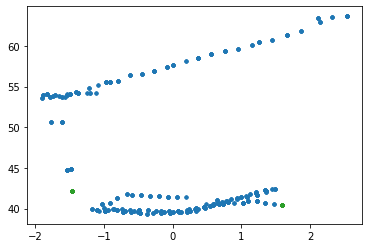

In [44]:
data_idx=2
pointset=ps_list[data_idx]
plt.plot(pointset[:,0],pointset[:,2],'.')
#plt.plot(pointset_before_transformation[:,0],pointset_before_transformation[:,2],'.')
plt.plot(pointset[segp_list[data_idx],0],pointset[segp_list[data_idx],2],'.')
plt.plot(pointset[seg_list[data_idx],0],pointset[seg_list[data_idx],2],'.')
#plt.plot(box3d_center[0],box3d_center[2],'.',markersize=10)
#plt.ylim([4,6])
#plt.xlim([-1,1])

In [45]:
15589/3

5196.333333333333

In [46]:
center_list[data_idx]

array([ 0.15792966,  1.4130286 , 41.30577469])

In [47]:
dataset[data_idx][2]

array([ 0.141579  ,  1.415     , 41.35954129])